To open on Google Colab [link](https://colab.research.google.com/github/RodrigoAVargasHdz/CHEM-4PB3/blob/main/Course_Notes/Week8/convNet.ipynb)

In [ ]:
!pip install rdkit-pypi

# CHEMINFORMATICS in the era of ML

[paper](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-018-2523-5)

In [2]:
import pandas as pd
import numpy as np
import pandas as pd
# rdkit stuff
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import PandasTools

import matplotlib
import matplotlib.pyplot as plt

In [25]:
# data from https://github.com/aspuru-guzik-group/chemical_vae
data_url = "https://github.com/aspuru-guzik-group/chemical_vae/raw/main/models/zinc_properties/250k_rndm_zinc_drugs_clean_3.csv"
data_total = pd.read_csv(data_url)

# The total number of data points is HUGE, lets sample 10K random
N = 10000
data = data_total.sample(N)
print(data.head)

# ----------------------------------------------
# Extra dataset for Classification for Toxicity 
# be careful as the data set is UNBALANCE
# data_url = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/clintox.csv.gz"
# df = pd.read_csv(data_url, compression='gzip', header=0,
                #  sep=',', quotechar='"', error_bad_lines=False)


<bound method NDFrame.head of                                                    smiles     logP       qed  \
103177  C[C@@H](OC(=O)c1cnn(C)c1)C(=O)N[C@@H]1CCC[C@@H...  1.90630  0.867609   
122527  C[C@H]1CCCC[C@@H]1OCCN(C)Cc1nc(=O)c2ccccc2[nH]1\n  2.95020  0.876849   
167236  Cc1ccc(O)c(Nc2c([N+](=O)[O-])c(=O)oc3ccccc23)c1\n  3.45882  0.324783   
129500               Cc1cccc(/C=N/NC(=O)c2ccc(Cl)cc2)n1\n  2.80732  0.686094   
12155   Cc1cc(NC(=O)C(C)(C)Oc2ccc(Cl)cc2)n(-c2nc([O-])...  2.38052  0.505232   
...                                                   ...      ...       ...   
164888  CC(C)[C@@H](NC(=O)N[C@H]1CCS(=O)(=O)C1)C(=O)[O... -1.75280  0.670671   
130709  CCN1c2nc3ccccc3nc2[C@@H](C2[NH+]=c3ccccc3=[NH+... -3.43840  0.465116   
242579  O=C(NC[C@@H]1CCCCO1)C(=O)Nc1ccc2[nH]c(C(F)F)nc...  2.12430  0.737401   
32060   C[C@@H](NC(=O)c1cc(N2CCCC2=O)ccc1Cl)[C@H](C)c1...  4.38880  0.812084   
70100                    CN(Cc1ccccc1O)C(=O)CSCc1cccnc1\n  2.67900  0.887499   

         

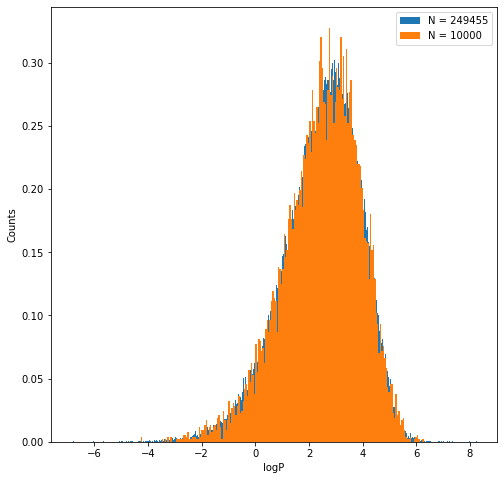

In [31]:
plt.figure(figsize=(8,8))
plt.hist(data_total.logP.to_numpy(),bins=1000,density=True,label='N = %s'%data_total.shape[0])
plt.hist(data.logP.to_numpy(),bins=200,density=True,label='N = %s'%data.shape[0])
plt.xlabel('logP')
plt.ylabel('Counts')
plt.legend()

In [34]:
def get_canonical_smiles(molec_smiles):
    molecule = AllChem.MolFromSmiles(molec_smiles)
    return AllChem.MolToSmiles(molecule, canonical=True)

8550 6857
Smallest molecule (16), Nc1cccc(Br)c1CO

Largest molecule (94), COc1ccc2c(c1)[C@]1(C(=O)N2)[C@@H]2C(=O)N(c3cccc([N+](=O)[O-])c3C)C(=O)[C@H]2[C@@H]2CCC[NH+]21



Text(0.5, 0, 'Length of SMILES')

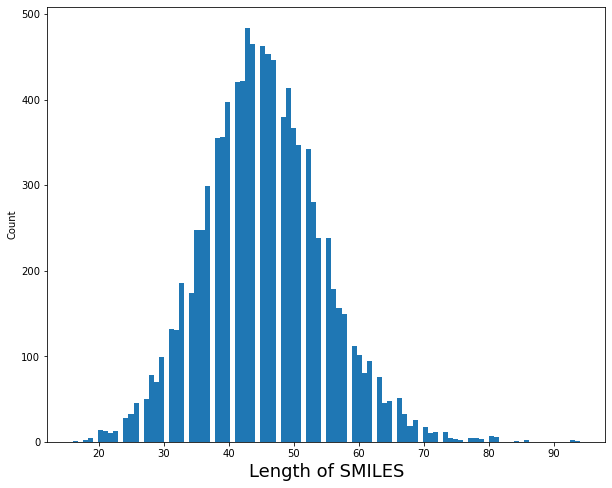

In [47]:
smiles_all = data.smiles.to_list()
length_smiles = []
for s in smiles_all:
    length_smiles.append(len(s))
length_smiles = np.array(length_smiles)


i_min = np.argmin(length_smiles)
i_max = np.argmax(length_smiles)
print(i_min,i_max)
print('Smallest molecule (%s), %s'%(length_smiles[i_min],smiles_all[i_min]))
print('Largest molecule (%s), %s' % (length_smiles[i_max], smiles_all[i_max]))


plt.figure(figsize=(10,8))
plt.hist(length_smiles,bins=100)
plt.ylabel('Count')
plt.xlabel('Length of SMILES',fontsize=18)

['CN1C=NC2=C1C(=O)N(C(=O)N2C)C']
(100, 35)


([<matplotlib.axis.YTick at 0x13b8ce670>,
 [Text(0, 0, '7'),
  Text(0, 1, '6'),
  Text(0, 2, 'o'),
  Text(0, 3, ']'),
  Text(0, 4, '3'),
  Text(0, 5, 's'),
  Text(0, 6, '('),
  Text(0, 7, '-'),
  Text(0, 8, 'S'),
  Text(0, 9, '/'),
  Text(0, 10, 'B'),
  Text(0, 11, '4'),
  Text(0, 12, '['),
  Text(0, 13, ')'),
  Text(0, 14, '#'),
  Text(0, 15, 'I'),
  Text(0, 16, 'l'),
  Text(0, 17, 'O'),
  Text(0, 18, 'H'),
  Text(0, 19, 'c'),
  Text(0, 20, '1'),
  Text(0, 21, '@'),
  Text(0, 22, '='),
  Text(0, 23, 'n'),
  Text(0, 24, 'P'),
  Text(0, 25, '8'),
  Text(0, 26, 'C'),
  Text(0, 27, '2'),
  Text(0, 28, 'F'),
  Text(0, 29, '5'),
  Text(0, 30, 'r'),
  Text(0, 31, 'N'),
  Text(0, 32, '+'),
  Text(0, 33, '\\'),
  Text(0, 34, ' ')])

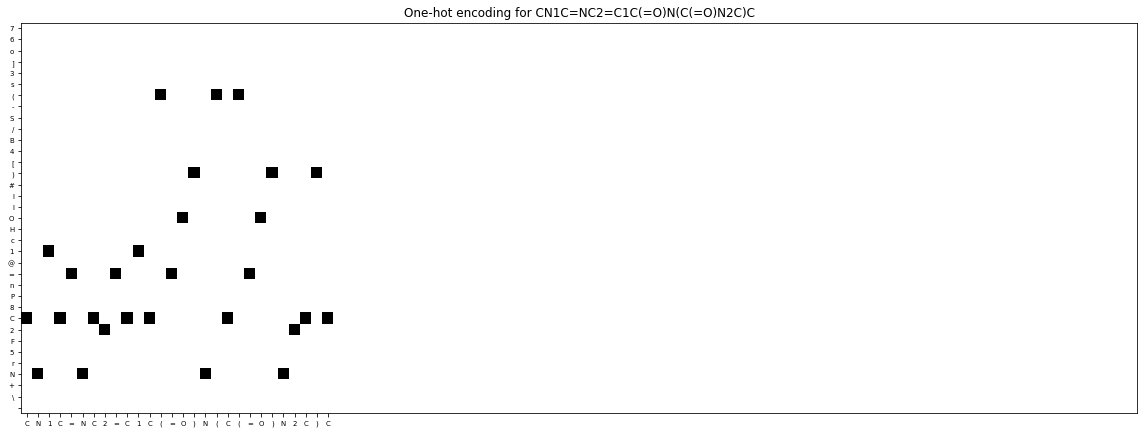

In [68]:
# ALPHABET: define SMILES characters 

max_len = 100
SMILES_CHARS = ["7", "6", "o", "]", "3", "s", "(", "-", "S", "/", "B", "4", "[", ")", "#", "I",
                "l", "O", "H", "c", "1", "@", "=", "n", "P", "8", "C", "2", "F", "5", "r", "N", "+", "\\", " "]
# index
smi2index = dict((c, i) for i, c in enumerate(SMILES_CHARS))


def smiles_to_one_hot(smiles, maxlen=max_len):
    X = np.zeros((maxlen, len(SMILES_CHARS)))  # (maxlen, dictionary)
    for i, c in enumerate(smiles):
        X[i, smi2index[c]] = 1
    return X


# caffeine one hot
caffeine_smiles = 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'
print(caffeine_smiles.split())

caffeine_one_hot = smiles_to_one_hot(caffeine_smiles)

print(caffeine_one_hot.shape)  # (120, 56)


plt.figure(figsize=(20,20))
plt.imshow(caffeine_one_hot.T,cmap='binary')
# plt.xlabel('Tokens')
# plt.ylabel('SMILES')


caffeine_smiles_pad = caffeine_smiles + " " * (max_len - len(caffeine_smiles))

plt.title('One-hot encoding for %s'%caffeine_smiles)
plt.xticks(np.arange(len(list(caffeine_smiles))),
           list(caffeine_smiles), fontsize=7)
plt.yticks(np.arange(len(list(SMILES_CHARS))),
           list(SMILES_CHARS), fontsize=7)


## Data preprocessing



In [32]:
# from rdkit import Chem
molecule = Chem.MolFromSmiles('OCCC')
unique_smiles = Chem.MolToSmiles(molecule, canonical=True)
print(unique_smiles)


CCCO
